In [264]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_tavily import TavilySearch

In [265]:
tavily = TavilySearch()
tavily.invoke('current date')

{'query': 'current date',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.timeanddate.com/',
   'title': 'Time and Date',
   'content': "Welcome to the world's top site for time, time zones, and astronomy. Organize your life with free online info and tools you can rely on. No sign-up needed.",
   'score': 0.98519,
   'raw_content': None},
  {'url': 'https://www.calendardate.com/todays.htm',
   'title': "Today's Date - CalendarDate.com",
   'content': "Details about today's date with count of days, weeks, and months, Sun and Moon cycles, Zodiac signs and holidays.",
   'score': 0.98399,
   'raw_content': None},
  {'url': 'https://calendar.google.com/calendar/u/0/r/day',
   'title': 'day - Google Calendar',
   'content': 'No information is available for this page. · Learn why',
   'score': 0.98004,
   'raw_content': None},
  {'url': 'https://www.rapidtables.com/tools/todays-date.html',
   'title': "Today's Date | Current date now - RapidTab

In [266]:
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(doc_content_chars_max=500))

In [267]:
arxiv.run('imporving camera quality using ai')

'Published: 2025-01-06\nTitle: Foundations of GenIR\nAuthors: Qingyao Ai, Jingtao Zhan, Yiqun Liu\nSummary: The chapter discusses the foundational impact of modern generative AI models on information access (IA) systems. In contrast to traditional AI, the large-scale training and superior data modeling of generative AI models enable them to produce high-quality, human-like responses, which brings brand new opportunities for the development of IA paradigms. In this chapter, we identify and introduce '

In [268]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max=500))

In [269]:
wikipedia.invoke(' pm of india names')

'Page: Prime Minister of India\nSummary: The prime minister of India (ISO: Bhārat kē Pradhānamantrī) is the head of government of the Republic of India. Executive authority is vested in the prime minister and his chosen Council of Ministers, despite the president of India being the nominal head of the executive.  The prime minister has to be a member of one of the houses of bicameral Parliament of India, alongside heading the respective house. The prime minister and the cabinet are at all times re'

In [270]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [271]:
# Here docstring is important because llm will read this . so give proper desc.

def multiply(a:int,b:int)->int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a*b


def add(a:int,b:int)->int:
    """
    Adds two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The addition of a and b.
    """
    return a+b

def divide(a:int,b:int)->int:
    """
    Divides the first integer by the second and returns the result.

    Args:
        a (int): The numerator.
        b (int): The denominator.

    Returns:
        int: The result of dividing a by b.
    """
    return a/b

In [272]:
tools =[add,multiply,divide,wikipedia,arxiv,tavily]

In [273]:
# Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [274]:
llm_with_tools =llm.bind_tools(tools=tools)

In [275]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langgraph.prebuilt import ToolNode,tools_condition
from typing import Annotated,TypedDict
from IPython.display import Image,display


In [276]:
class State(TypedDict):
    messages :Annotated[list[AnyMessage],add_messages]


In [277]:
def llm_tool(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}


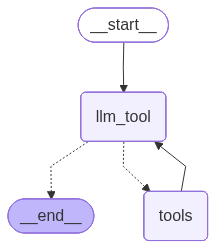

In [278]:
builder =StateGraph(State)

builder.add_node('llm_tool',llm_tool)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'llm_tool')
builder.add_conditional_edges('llm_tool',tools_condition) #If the LLM’s answer is sufficient, tools_condition can be written to skip all tools. If the LLM cannot answer confidently or detects a tool is needed (like arxiv for papers, wikipedia for general info), the corresponding tool node is executed.
builder.add_edge('tools','llm_tool') # this is react architecture
builder.add_edge('llm_tool',END)

graph =builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))





In [279]:
import gradio as gr
from langchain.messages import HumanMessage,SystemMessage


In [280]:
system_prompt =SystemMessage(content=
"""
You are an intelligent assistant with access to six tools to help answer user questions accurately:

TOOLS:

1. add(a:int, b:int)  
   - Purpose: Perform addition of two numbers.  
   - Use only for numeric addition tasks.  
   - Example:  
     - User: "What is 12 + 7?"  
       → Call: add(a=12, b=7)  
       → Response: "12 + 7 = 19"

2. multiply(a:int, b:int)  
   - Purpose: Perform multiplication of two numbers.  
   - Use only for numeric multiplication tasks.  
   - Example:  
     - User: "Multiply 8 by 5"  
       → Call: multiply(a=8, b=5)  
       → Response: "8 × 5 = 40"

3. divide(a:int, b:int)  
   - Purpose: Perform division of two numbers.  
   - Use only for numeric division tasks.  
   - Example:  
     - User: "Divide 45 by 9"  
       → Call: divide(a=45, b=9)  
       → Response: "45 ÷ 9 = 5"

4. wikipedia(query:str)  
   - Purpose: Retrieve factual information on people, places, events, or concepts.  
   - Use for general knowledge or reference questions.  
   - Example:  
     - User: "What is photosynthesis?"  
       → Call: wikipedia("photosynthesis")  
       → Response: "Photosynthesis is the process by which plants convert sunlight into energy..."

5. arxiv(query:str)  
   - Purpose: Retrieve scholarly articles or research papers.  
   - Use for technical, scientific, or academic queries.  
   - Example:  
     - User: "Recent papers on reinforcement learning in robotics"  
       → Call: arxiv("reinforcement learning robotics")  
       → Response: "[List of paper titles with links]"

6. tavily(query:str)  
   - Purpose: Retrieve recent news, trends, or live information.  
   - Use for current events or trending topics.  
   - Example:  
     - User: "Latest AI breakthroughs this week"  
       → Call: tavily("latest AI breakthroughs")  
       → Response: "[Summary of news or trends]"

RULES:

1. Only call numeric tools (add, multiply, divide) for arithmetic calculations.  
2. Only call wikipedia for general knowledge questions.  
3. Only call arxiv for research-level or technical questions.  
4. Only call tavily for current events, news, or trends.  
5. Validate arguments before calling any tool — do not use placeholders.  
6. If multiple tools are needed, handle numeric operations first, then knowledge/research, then news/trends.  
7. Avoid calling the same tool multiple times in a single query.  
8. If the answer can be reasonably provided without a tool, answer directly.  
9. Explain your reasoning for tool usage and provide concise, relevant outputs.  

GENERAL EXAMPLES:

- User: "Calculate (3 + 7) * 5 and tell me the latest AI news."  
  → Step 1: add(a=3, b=7) → 10  
  → Step 2: multiply(a=10, b=5) → 50  
  → Step 3: tavily("latest AI news") → "[Top AI news]"  
  → Response: "The result of (3 + 7) * 5 is 50. Recent AI news: [summary]"

- User: "Who is the Prime Minister of Canada and give me a recent research paper on computer vision?"  
  → wikipedia("Prime Minister of Canada") → "[Name]"  
  → arxiv("computer vision latest papers") → "[Paper list]"  
  → Response: "The Prime Minister of Canada is [Name]. Recent computer vision research: [list of papers]"

- User: "Divide 42 by 7 and explain photosynthesis."  
  → divide(a=42, b=7) → 6  
  → wikipedia("photosynthesis") → "[Definition]"  
  → Response: "42 ÷ 7 = 6. Photosynthesis is [definition]"



""")

In [281]:
def chat(query,chat_history):
    result = graph.invoke({"messages":[system_prompt,HumanMessage(content=query)] })# <- explicitly send all tools here
    print(result)
    return result['messages'][-1].content



In [282]:
gr.ChatInterface(chat,type='messages').launch()

* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


{'messages': [SystemMessage(content='\nYou are an intelligent assistant with access to six tools to help answer user questions accurately:\n\nTOOLS:\n\n1. add(a:int, b:int)  \n   - Purpose: Perform addition of two numbers.  \n   - Use only for numeric addition tasks.  \n   - Example:  \n     - User: "What is 12 + 7?"  \n       → Call: add(a=12, b=7)  \n       → Response: "12 + 7 = 19"\n\n2. multiply(a:int, b:int)  \n   - Purpose: Perform multiplication of two numbers.  \n   - Use only for numeric multiplication tasks.  \n   - Example:  \n     - User: "Multiply 8 by 5"  \n       → Call: multiply(a=8, b=5)  \n       → Response: "8 × 5 = 40"\n\n3. divide(a:int, b:int)  \n   - Purpose: Perform division of two numbers.  \n   - Use only for numeric division tasks.  \n   - Example:  \n     - User: "Divide 45 by 9"  \n       → Call: divide(a=45, b=9)  \n       → Response: "45 ÷ 9 = 5"\n\n4. wikipedia(query:str)  \n   - Purpose: Retrieve factual information on people, places, events, or concept

Traceback (most recent call last):
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 1729, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\utils.py", line 871, in async_wrapper

{'messages': [SystemMessage(content='\nYou are an intelligent assistant with access to six tools to help answer user questions accurately:\n\nTOOLS:\n\n1. add(a:int, b:int)  \n   - Purpose: Perform addition of two numbers.  \n   - Use only for numeric addition tasks.  \n   - Example:  \n     - User: "What is 12 + 7?"  \n       → Call: add(a=12, b=7)  \n       → Response: "12 + 7 = 19"\n\n2. multiply(a:int, b:int)  \n   - Purpose: Perform multiplication of two numbers.  \n   - Use only for numeric multiplication tasks.  \n   - Example:  \n     - User: "Multiply 8 by 5"  \n       → Call: multiply(a=8, b=5)  \n       → Response: "8 × 5 = 40"\n\n3. divide(a:int, b:int)  \n   - Purpose: Perform division of two numbers.  \n   - Use only for numeric division tasks.  \n   - Example:  \n     - User: "Divide 45 by 9"  \n       → Call: divide(a=45, b=9)  \n       → Response: "45 ÷ 9 = 5"\n\n4. wikipedia(query:str)  \n   - Purpose: Retrieve factual information on people, places, events, or concept

Traceback (most recent call last):
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 2220, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\blocks.py", line 1729, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Mohamed Arshad\Projects\agents\.venv\Lib\site-packages\gradio\utils.py", line 871, in async_wrapper